# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

In [188]:
# external_input_params = {
#     "external_input_type": "two_peaks_with_varying_timing",
#     "std1": 10,
#     "corr1": 0.0,
#     "std2": 10,
#     "corr2": 0.0,
#     "use_two_modes": True,
# }

external_input_params = {
    "external_input_type": "two_peaks_with_varying_baseline_slope",
    "max_slope": 0.01,
    "min_slope": -0.01,
    # "max_slope": 0.0,
    # "min_slope": -0.0,
}

spikes, trial_info, current = GLM.EIF_simulator(
    ntrial=2000,
    nneuron=50,
    conn=0.0,
    params=external_input_params, 
    return_trial_info=True,
    return_current=True,
)

print(f"Size of spikes array in MB: {spikes.nbytes / (1024 * 1024):.2f} MB")


100%|██████████| 2000/2000 [03:17<00:00, 10.12it/s]

Size of spikes array in MB: 228.88 MB


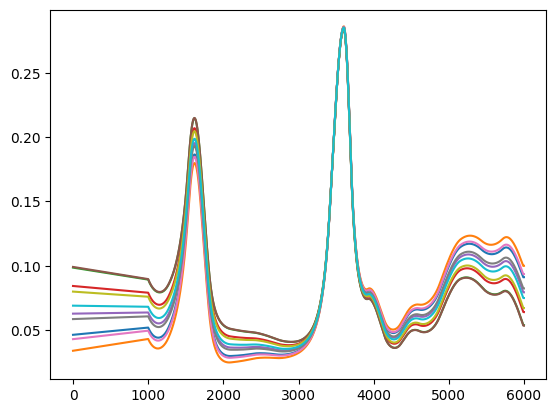

In [189]:
plt.plot(current[:,0,0:10])

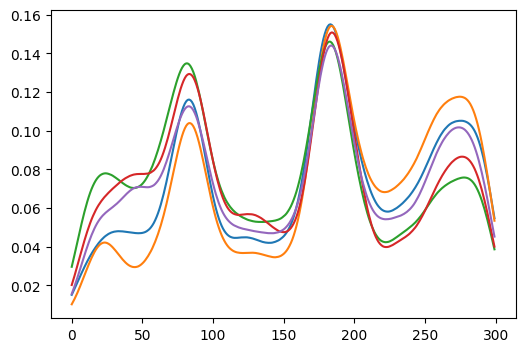

In [215]:
plt.figure(figsize=(6,4))
# Define Gaussian kernel for smoothing
kernel_width = 10
kernel = np.exp(-np.arange(-3*kernel_width, 3*kernel_width+1)**2 / (2*kernel_width**2))
kernel = kernel / kernel.sum()  # Normalize

for trial in range(5):  # Plot first 20 trials
    # Get mean across neurons for this trial
    trial_mean = spikes[:,:,trial].mean(axis=1)
    # Apply kernel smoothing via convolution
    smoothed = np.convolve(trial_mean, kernel, mode='same')
    plt.plot(smoothed)


Text(0.5, 1.0, 'Spike raster for neuron 0')

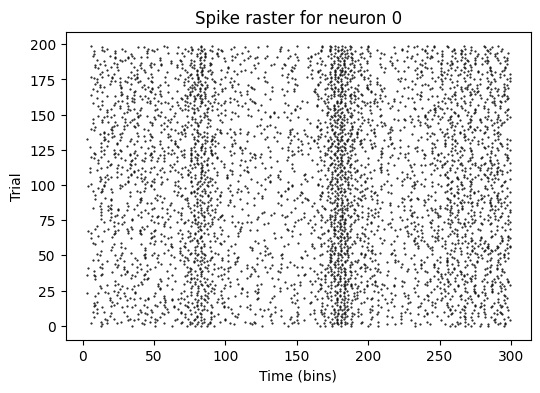

In [190]:
# Plot raster for one example neuron
neuron_idx = 0  # Choose first neuron
plt.figure(figsize=(6,4))
for trial in range(200):  # Plot first 20 trials
    spike_times = np.where(spikes[:,neuron_idx,trial])[0]
    plt.plot(spike_times, trial*np.ones_like(spike_times), '.', markersize=1, color='black')
plt.xlabel('Time (bins)')
plt.ylabel('Trial')
plt.title(f'Spike raster for neuron {neuron_idx}')


In [226]:
nneuron = spikes.shape[1]//2

synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron,:], spikes[:,nneuron:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

In [227]:
for batch in synthetic_dataloader.train_loader:
    print(batch['spike_trains'].shape)
    break

torch.Size([300, 50, 64])


# Train a model

Current problems:
- Not stable! Run the code multiple times, the results are different. **Solved by temporal correlation penalty**
- The coupling effect is not capturing what it should capture. ** **

Things I want to try:
- see if the baseline looks good. **YES**
- I want to get a clear two modes in t-sne plot, since the ground truth is two modes. **YES**
- Play with hyperparameters, see what appect the results. **lr is still very important. Epoch is also important.**
- Try make coupling effect weaker by setting initial value to be around zero. I don't want to see the coupling effect being too strong. **can be done by frozing Transformer encoder**
- See how would overlapping penalty affect the results. overlapping_penalty=None: 0.2283
overlapping_penalty=1e0: 0.2289. **but overlapping penalty makes coupling very small**
- Try penalty temporal correlation. **Works great!**
- Try not frozing Transformer encoder. **(a different dataset than the previous one) 0.2300 vs 0.2308. So Yes, frozing encoder**
- Try cls token. **No, will lead to mode collapse**
- Get a set of hyperparameters that works in both conn=0.0 and conn=0.01. ** **
- compare with no f(z,t) but just f(t). The coupling effect should be much stronger. 


- I don't know why the first element in both sending and receiving weights are much larger than the rest.


In [ ]:
fit_baseline = True

# data_to_use = cross_session_dataloader
data_to_use = synthetic_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

torch.manual_seed(0)
np.random.seed(0)

params = {
    # B-spline basis
    'num_B_spline_basis': 50,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 2,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    # Coupling's settings
    'coupling_basis_peaks_max': 10,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_overlapping': 1e-3, 
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    # Currently not used
    'weight_decay': 0.0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if fit_baseline:
    # Baseline model: no trial-varying stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )

else:
    # First step: train the model with a trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )
    # Second step: train the model with a trial-varying stimulus effect
    # trainer.make_optimizer(frozen_params=['sti_readout'])
    trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )

    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )



/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 50, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 2, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': 0.001, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 316.89it/s]


Epoch 1/200, Train Loss: 0.9005, Test Loss: 0.3735


100%|██████████| 4/4 [00:00<00:00, 167.52it/s]


Epoch 2/200, Train Loss: 0.3640, Test Loss: 0.3397


100%|██████████| 4/4 [00:00<00:00, 311.55it/s]


Epoch 3/200, Train Loss: 0.3334, Test Loss: 0.3266


100%|██████████| 4/4 [00:00<00:00, 317.15it/s]


Epoch 4/200, Train Loss: 0.3207, Test Loss: 0.3143


100%|██████████| 4/4 [00:00<00:00, 300.28it/s]


Epoch 5/200, Train Loss: 0.3081, Test Loss: 0.3015


100%|██████████| 4/4 [00:00<00:00, 318.67it/s]


Epoch 6/200, Train Loss: 0.2961, Test Loss: 0.2907


100%|██████████| 4/4 [00:00<00:00, 301.42it/s]


Epoch 7/200, Train Loss: 0.2869, Test Loss: 0.2833


100%|██████████| 4/4 [00:00<00:00, 308.80it/s]


Epoch 8/200, Train Loss: 0.2810, Test Loss: 0.2789


100%|██████████| 4/4 [00:00<00:00, 296.07it/s]


Epoch 9/200, Train Loss: 0.2777, Test Loss: 0.2766


100%|██████████| 4/4 [00:00<00:00, 310.79it/s]


Epoch 10/200, Train Loss: 0.2760, Test Loss: 0.2754


100%|██████████| 4/4 [00:00<00:00, 316.80it/s]


Epoch 11/200, Train Loss: 0.2750, Test Loss: 0.2747


100%|██████████| 4/4 [00:00<00:00, 274.09it/s]


Epoch 12/200, Train Loss: 0.2745, Test Loss: 0.2743


100%|██████████| 4/4 [00:00<00:00, 297.46it/s]


Epoch 13/200, Train Loss: 0.2742, Test Loss: 0.2740


100%|██████████| 4/4 [00:00<00:00, 299.78it/s]


Epoch 14/200, Train Loss: 0.2739, Test Loss: 0.2738


100%|██████████| 4/4 [00:00<00:00, 297.86it/s]


Epoch 15/200, Train Loss: 0.2738, Test Loss: 0.2737


100%|██████████| 4/4 [00:00<00:00, 299.56it/s]


Epoch 16/200, Train Loss: 0.2737, Test Loss: 0.2736


100%|██████████| 4/4 [00:00<00:00, 309.19it/s]


Epoch 17/200, Train Loss: 0.2736, Test Loss: 0.2735


100%|██████████| 4/4 [00:00<00:00, 151.76it/s]


Epoch 18/200, Train Loss: 0.2735, Test Loss: 0.2734


100%|██████████| 4/4 [00:00<00:00, 284.38it/s]


Epoch 19/200, Train Loss: 0.2734, Test Loss: 0.2733


100%|██████████| 4/4 [00:00<00:00, 291.28it/s]


Epoch 20/200, Train Loss: 0.2733, Test Loss: 0.2732


100%|██████████| 4/4 [00:00<00:00, 313.05it/s]


Epoch 21/200, Train Loss: 0.2732, Test Loss: 0.2731


100%|██████████| 4/4 [00:00<00:00, 297.05it/s]


Epoch 22/200, Train Loss: 0.2732, Test Loss: 0.2731


100%|██████████| 4/4 [00:00<00:00, 274.16it/s]


Epoch 23/200, Train Loss: 0.2731, Test Loss: 0.2730


100%|██████████| 4/4 [00:00<00:00, 295.74it/s]


Epoch 24/200, Train Loss: 0.2730, Test Loss: 0.2730


100%|██████████| 4/4 [00:00<00:00, 136.61it/s]


Epoch 25/200, Train Loss: 0.2730, Test Loss: 0.2729


100%|██████████| 4/4 [00:00<00:00, 319.35it/s]


Epoch 26/200, Train Loss: 0.2729, Test Loss: 0.2729


100%|██████████| 4/4 [00:00<00:00, 325.56it/s]


Epoch 27/200, Train Loss: 0.2729, Test Loss: 0.2728


100%|██████████| 4/4 [00:00<00:00, 325.57it/s]


Epoch 28/200, Train Loss: 0.2728, Test Loss: 0.2728


100%|██████████| 4/4 [00:00<00:00, 228.38it/s]


Epoch 29/200, Train Loss: 0.2728, Test Loss: 0.2727


100%|██████████| 4/4 [00:00<00:00, 310.11it/s]


Epoch 30/200, Train Loss: 0.2728, Test Loss: 0.2727


100%|██████████| 4/4 [00:00<00:00, 320.34it/s]


Epoch 31/200, Train Loss: 0.2727, Test Loss: 0.2727


100%|██████████| 4/4 [00:00<00:00, 298.27it/s]


Epoch 32/200, Train Loss: 0.2727, Test Loss: 0.2726


100%|██████████| 4/4 [00:00<00:00, 330.77it/s]

In [ ]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

100%|██████████| 7/7 [00:00<00:00, 265.07it/s]

Test loss: 0.27159337888929314
Test loss baseline: 0.28141102388018086


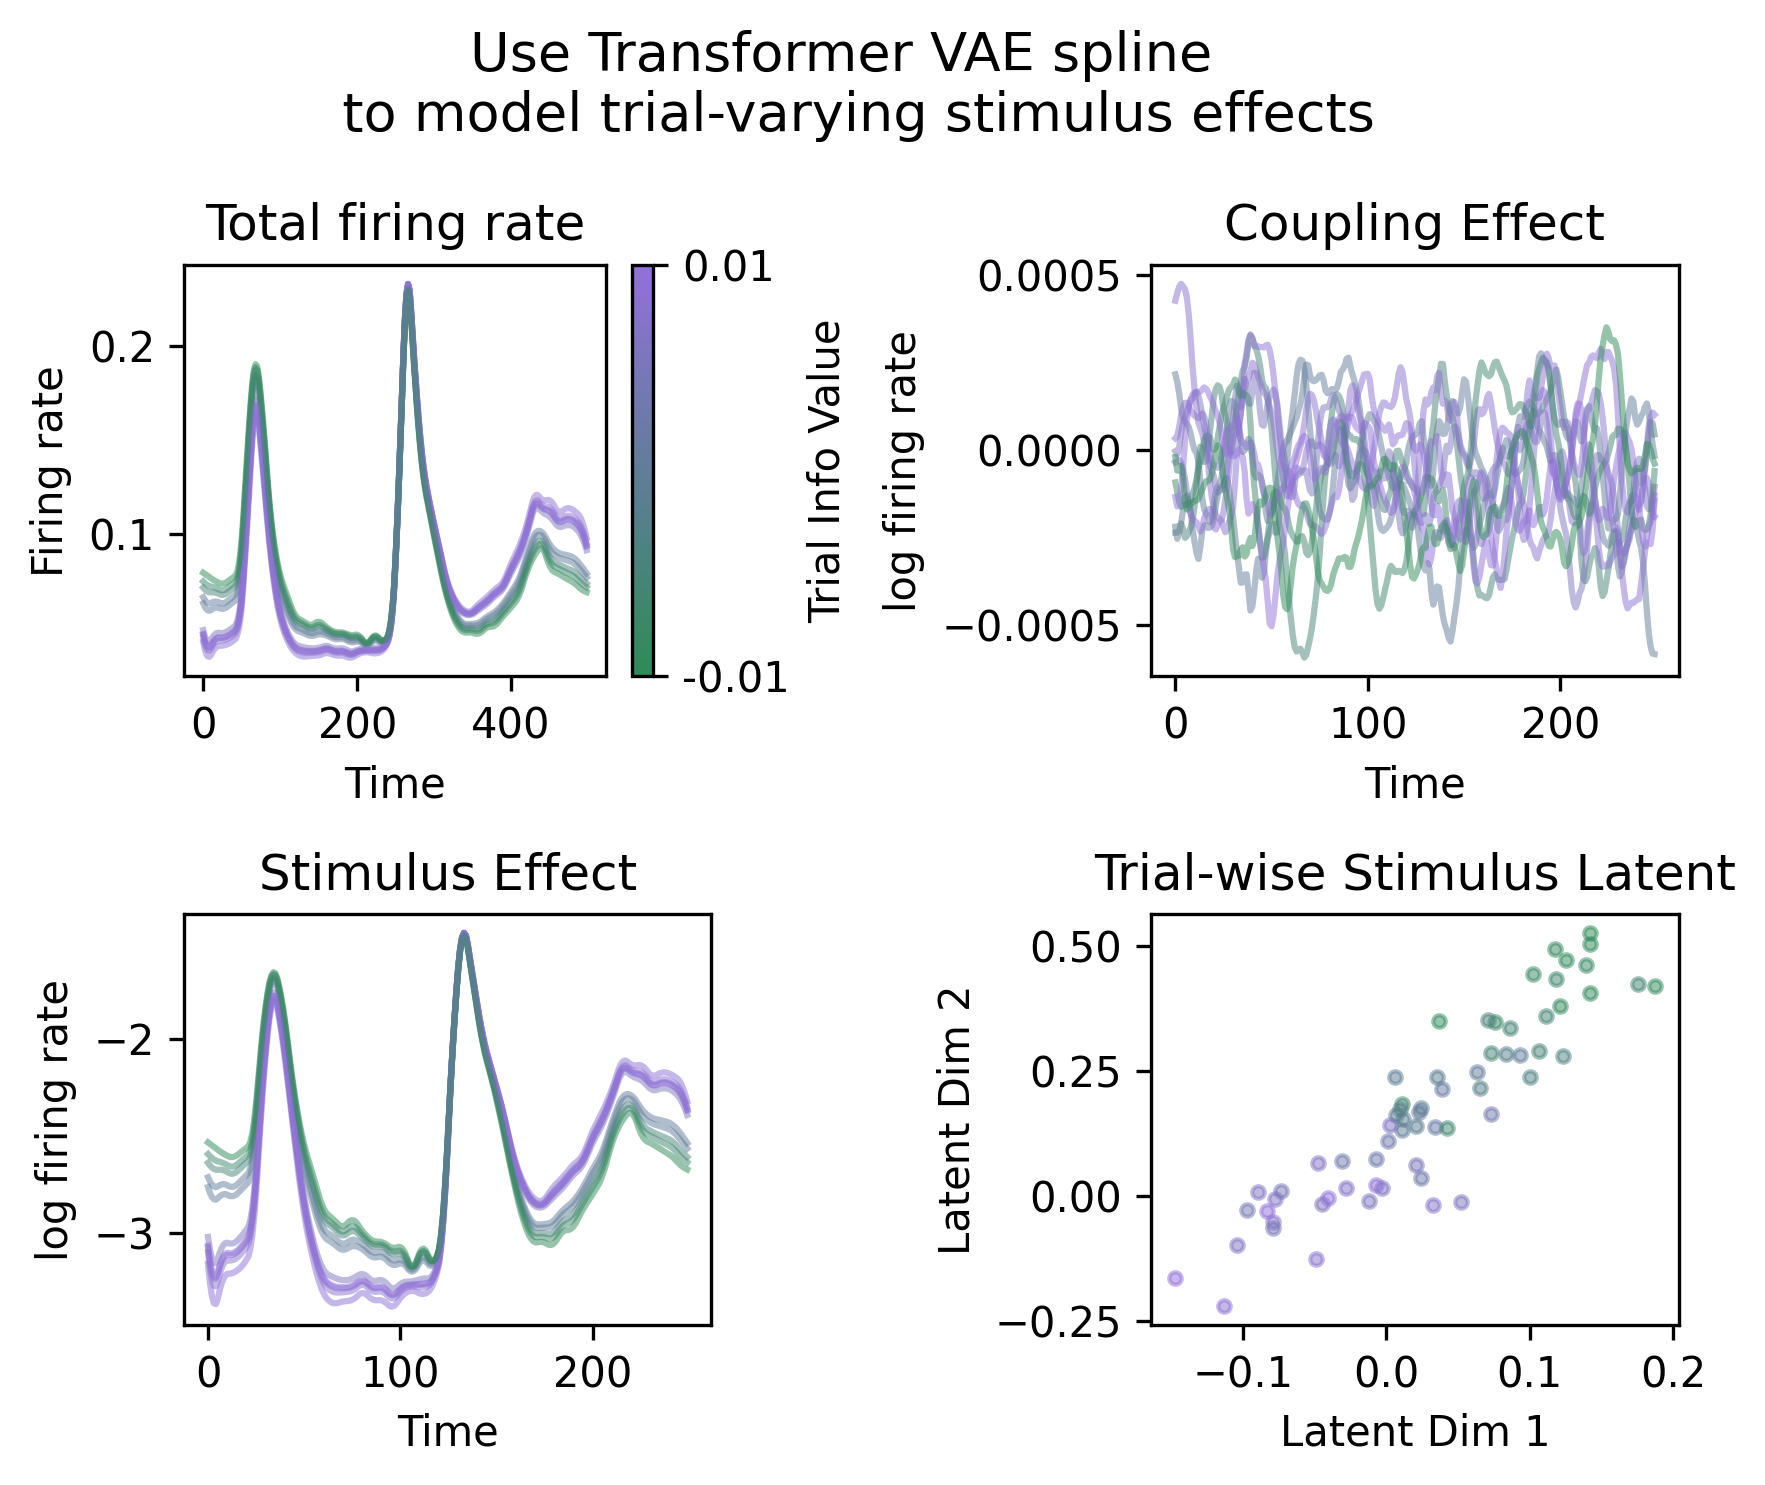

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.manifold import TSNE

local_trial_indices = np.arange(0, 10)
neuron_idx = -1

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=True,
)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Use Transformer VAE spline \n to model trial-varying stimulus effects', 
    fontsize=13
)

# Define colors for min and max values
color_min = '#2E8B57'  # Sea green for minimum value
color_max = '#9370DB'  # Purple for maximum value

# Get min and max of trial_info for normalization
if isinstance(trial_info, np.ndarray) and trial_info.dtype == bool:
    trial_info = trial_info.astype(int)
trial_info_subset = trial_info[trial_indices[local_trial_indices]]
info_min, info_max = np.min(trial_info), np.max(trial_info)

# Calculate normalized trial info
normalized_trial_info = (trial_info[trial_indices] - info_min) / (info_max - info_min)

# Create colormap and normalizer
cmap = LinearSegmentedColormap.from_list('custom', [color_min, color_max])
norm = Normalize(vmin=0, vmax=1)

# Plot total firing rate
xx = np.arange(firing_rate_test.shape[0]) * 2  # Adjusted x-axis
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx]))
    axes[0, 0].plot(
        xx, 
        np.exp(firing_rate_test[:, neuron_idx, trial_idx].cpu().numpy()), 
        color=color, 
        alpha=0.5
    )
axes[0, 0].set_title('Total firing rate')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Firing rate')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[0, 0])
cbar.set_label('Trial Info Value')
cbar.set_ticks([0, 1])
cbar.set_ticklabels([f'{info_min:.2f}', f'{info_max:.2f}'])

# Plot coupling effect
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx]))
    axes[0, 1].plot(
        trainer.model.firing_rates_coupling[trial_idx, neuron_idx, :].cpu().numpy(),
        color=color,
        alpha=0.5
    )
axes[0, 1].set_title('Coupling Effect')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('log firing rate')

# Plot stimulus effect
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx]))
    axes[1, 0].plot(
        trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(),
        color=color,
        alpha=0.5
    )
axes[1, 0].set_title('Stimulus Effect')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test

if sti_mu_test_np.shape[1] <= 2:
    for i in range(len(sti_mu_test_np)):
        color = cmap(norm(normalized_trial_info[i]))
        axes[1, 1].scatter(
            sti_mu_test_np[i, 0],
            sti_mu_test_np[i, 1],
            alpha=0.5,
            marker='.',
            c=[color]
        )
    axes[1, 1].set_title('Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('Latent Dim 1')
    axes[1, 1].set_ylabel('Latent Dim 2')
elif np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    for i in range(len(sti_mu_test_tsne)):
        color = cmap(norm(normalized_trial_info[i]))
        axes[1, 1].scatter(
            sti_mu_test_tsne[i, 0],
            sti_mu_test_tsne[i, 1],
            alpha=0.5,
            marker='.',
            c=[color]
        )
    axes[1, 1].set_title('t-SNE of the Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
else:
    print(
        f"Stimulus latent is not varying across trials: "
        f"{sti_mu_test_np.std(axis=0).mean()}"
    )

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)


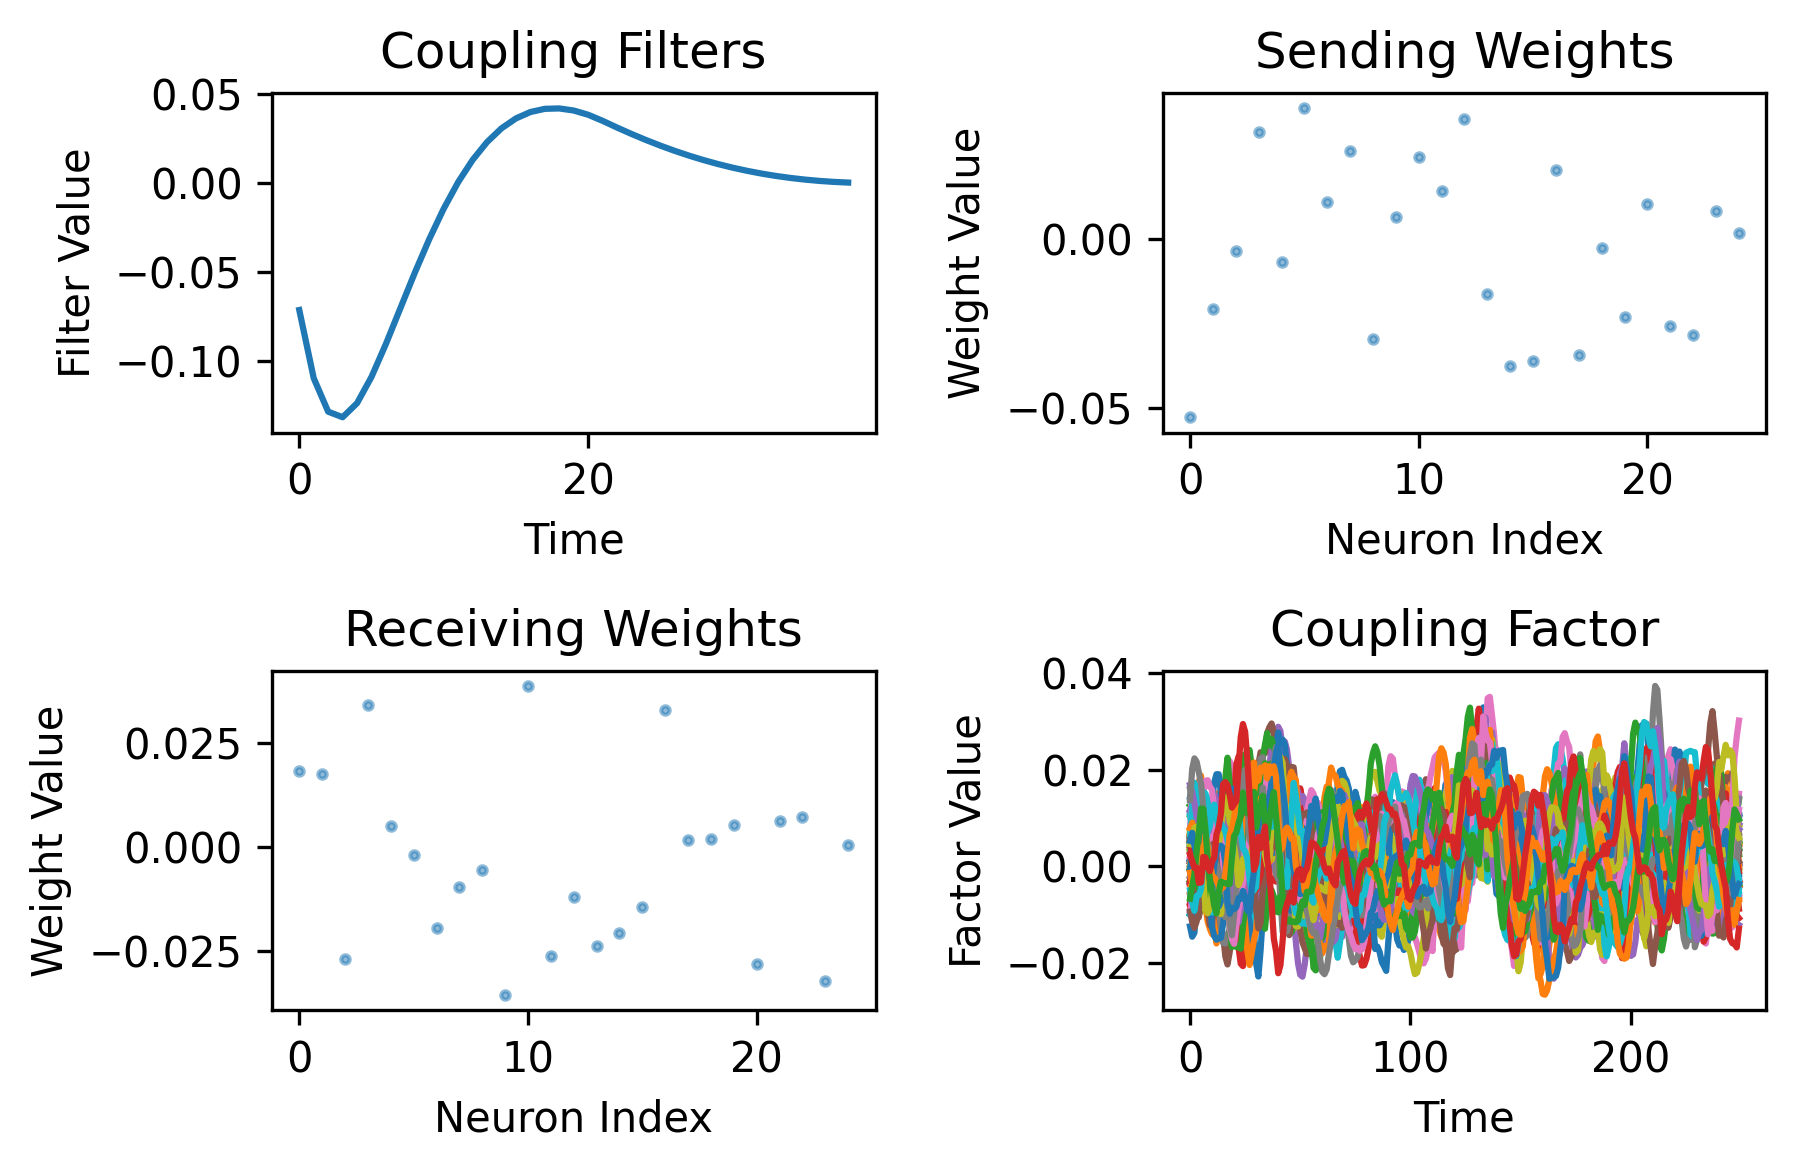

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4), dpi=300)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][0][1].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[0][1].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()
